In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import os, sys 
sys.path.append('../../src')

In [3]:
from spaceoracle.tools.network import MouseKidneyRegulatoryNetwork
co_grn = MouseKidneyRegulatoryNetwork()

2024-12-19 16:23:51.544568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/survey_kidney.h5ad')

In [5]:
from spaceoracle.oracles import SpaceTravLR

star = SpaceTravLR(
    adata, 
    save_dir='/ix/djishnu/shared/djishnu_kor11/models_kidney',
    annot='cluster_cat',
    grn=co_grn
)

star.adata

AnnData object with n_obs × n_vars = 6959 × 3000
    obs: 'cluster_cat'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_harmony_reordered', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'dim', 'imputed_count', 'normalized_count', 'npc-l1p', 'raw_count'
    obsp: 'connectivities', 'distances'

In [6]:
x_coord = adata.obsm['spatial'][:, 0]
y_coord = adata.obsm['spatial'][:, 1]

np.min(x_coord), np.max(x_coord), np.min(y_coord), np.max(y_coord)

(0, 17, 0, 35)

In [7]:
ko_candidates = np.loadtxt('../../data/kidney/kos.txt', dtype=str)
ko_candidates = [x.capitalize() for x in ko_candidates]
ko_candidates = set(ko_candidates) & set(adata.var_names)
ko_candidates

{'Bach2', 'Csf2', 'Ebf1', 'Flt3', 'Irf4', 'Pax5', 'Tcf7'}

In [ ]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

# test run to make sure everything is working

estimator = SpatialCellularProgramsEstimator(
    adata=star.adata,
    target_gene='Bach2',
    layer='imputed_count',
    cluster_annot='cluster_cat', 
    spatial_dim=32,
    grn=co_grn
)

estimator.fit(num_epochs=200, threshold_lambda=1e-12, learning_rate=5e-4)


In [ ]:
adata.layers['imputed_count'] = star.adata.layers['imputed_count']
adata.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/survey_kidney.h5ad')

In [8]:
# To view training progress

from spaceoracle.tools.network import MouseKidneyRegulatoryNetwork
from spaceoracle import SpaceTravLR

co_grn = MouseKidneyRegulatoryNetwork()

adata_train = sc.read_h5ad(
    '/ix/djishnu/shared/djishnu_kor11/training_data/survey_kidney.h5ad')

star = SpaceTravLR(
    adata=adata_train,
    annot='cluster_cat', 
    grn=co_grn,
    max_epochs=200, 
    learning_rate=5e-4, 
    spatial_dim=35,
    batch_size=512,
    threshold_lambda=1e-12,
    test_mode=False,
    save_dir='/ix/djishnu/shared/djishnu_kor11/models_kidney'
)

star.run()


Fitting Gm525 with 120 modulators
	11 Transcription Factors
	77 Ligand-Receptor Pairs
	32 TranscriptionFactor-Ligand Pairs
0: 0.7338 | -0.4983
1: 0.8757 | 0.1112
2: 0.9702 | -0.9299
3: 0.9767 | 0.5822
4: 0.9694 | 0.1739
5: 0.7027 | 0.9743
6: 0.8430 | 0.5220
7: 0.3478 | -0.6490
8: 0.9314 | 0.7005


Mac 0.48665395725896626
B 0.48863948848297856
T 0.4697185064946371
Endothelial_Anti-Apoptosis 0.47083597691480983
DC 0.4726168111812256
Granulocyte 0.47992094137075714
Endothelial_DVR 0.48833726366694846
Endothelial_Capilary 0.4871652236875163
Epithelial_Collecting_Duct 0.5428895424674347


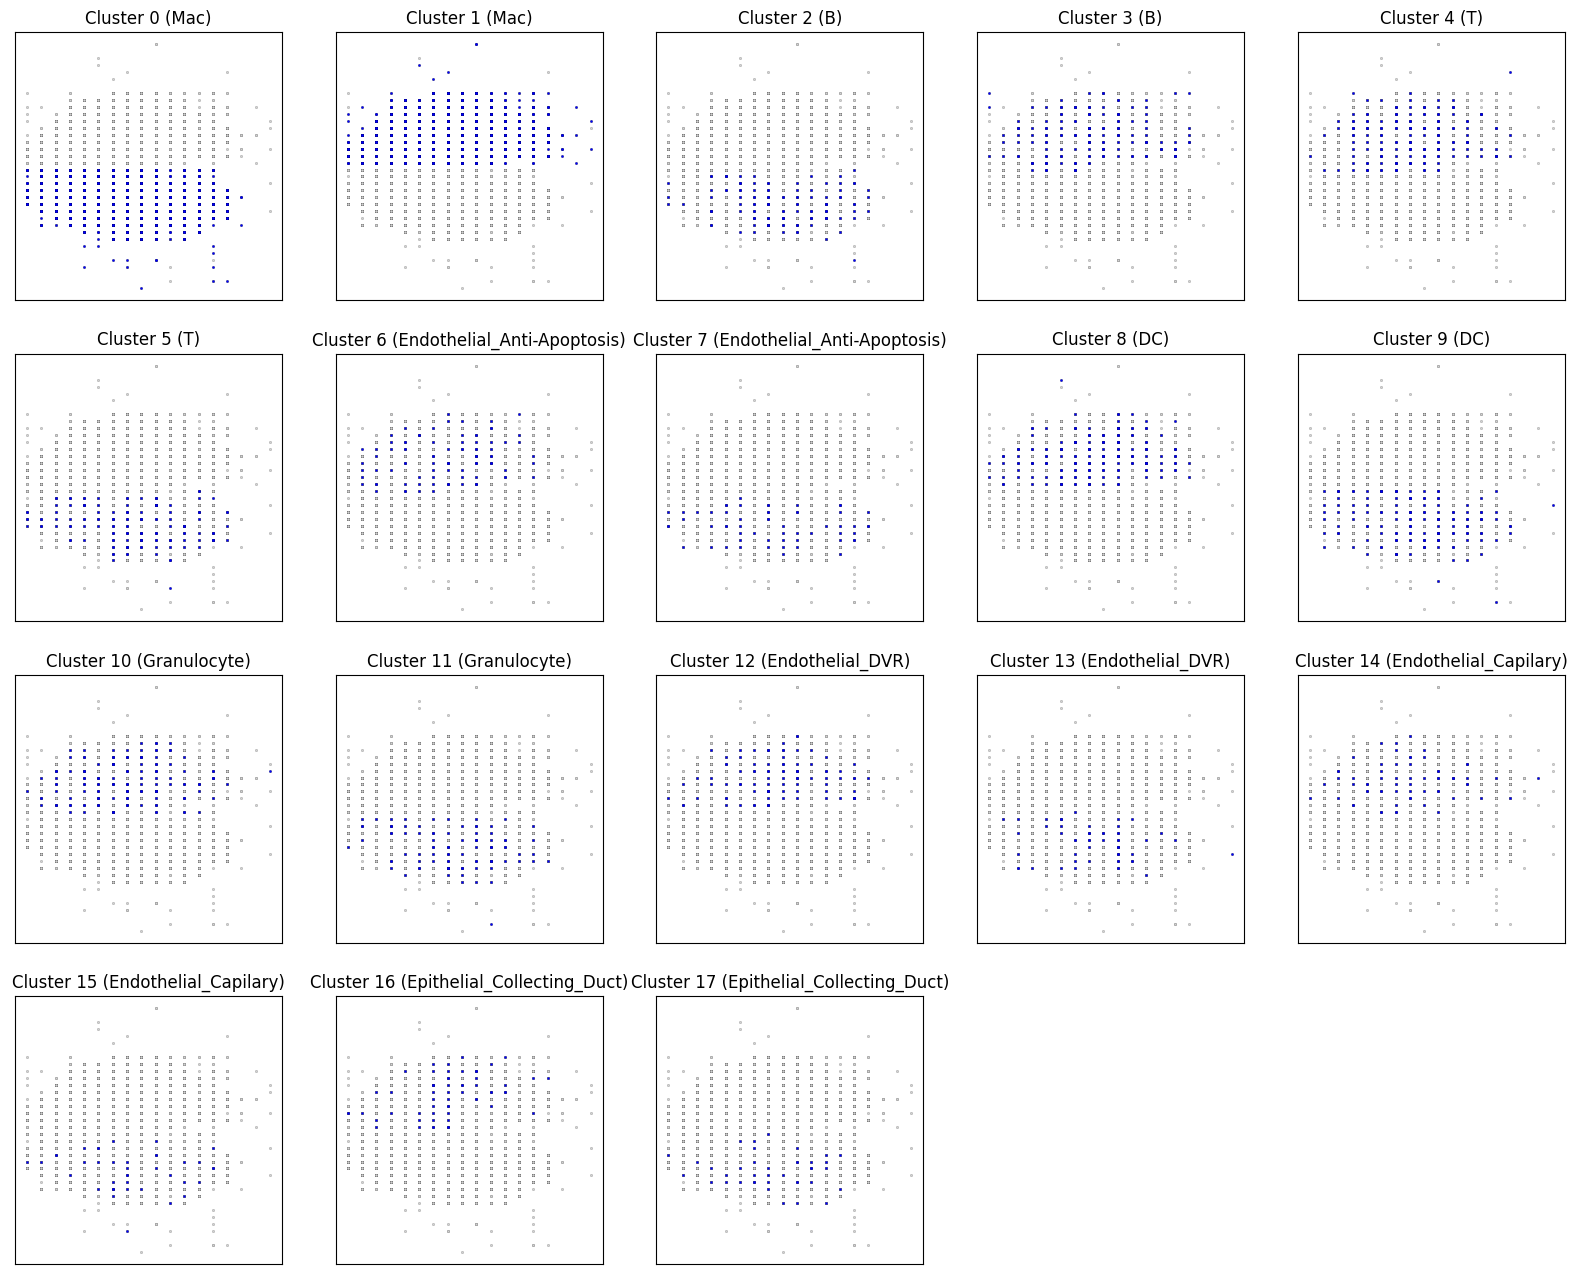

In [11]:
# to plot before training is finished 

from spaceoracle.plotting.niche import get_grid_layout
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

seed = 1
score_thresh = 0.2

cluster_annot = 'ct2'
clusters = adata.obs[cluster_annot]unique()
betas = estimator.betadata.values
cell_types = adata.obs[cluster_annot]
labels = np.full(len(betas), -1, dtype=int)
range_n_clusters = range(2, 5)  # Range of clusters to try

for cell_type in clusters:

    subset_idxs = np.where(cell_types == cell_type)[0]
    subset = betas[subset_idxs]

    best_score = -1
    best_n_clusters = 2

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
        cluster_labels = kmeans.fit_predict(subset)
        if len(set(cluster_labels)) > 1: 
            score = silhouette_score(subset, cluster_labels)
            if score > best_score:
                best_score = score
                best_n_clusters = n_clusters
    
    if best_score < score_thresh:  
        best_n_clusters = 1

    print(cell_type, best_score)

    best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=seed)
    best_labels = best_kmeans.fit_predict(subset)

    labels[subset_idxs] = best_labels + np.max(labels) + 1

rows, cols = get_grid_layout(len(np.unique(labels)), preferred_cols=None)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for i in np.unique(labels):
    cluster_mask = labels == i
    celltype = cell_types[cluster_mask][0]
    
    axes[i].scatter(
        adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
        c='lightgray', s=3, edgecolors='black', linewidth=0.1
    )
    
    axes[i].scatter(
        adata.obsm['spatial'][cluster_mask, 0], adata.obsm['spatial'][cluster_mask, 1],
        c='blue', s=3, edgecolors='black', linewidth=0.1
    )
    
    axes[i].set_title(f'Cluster {i} ({celltype})')
    axes[i].set_xticks([])  
    axes[i].set_yticks([])  

for j in range(i + 1, rows * cols):
    axes[j].axis('off')

Mac 0.48665395725896626
B 0.48863948848297856
T 0.4697185064946371
Endothelial_Anti-Apoptosis 0.47083597691480983
DC 0.4726168111812256
Granulocyte 0.47992094137075714
Endothelial_DVR 0.48833726366694846
Endothelial_Capilary 0.4871652236875163
Epithelial_Collecting_Duct 0.5428895424674347


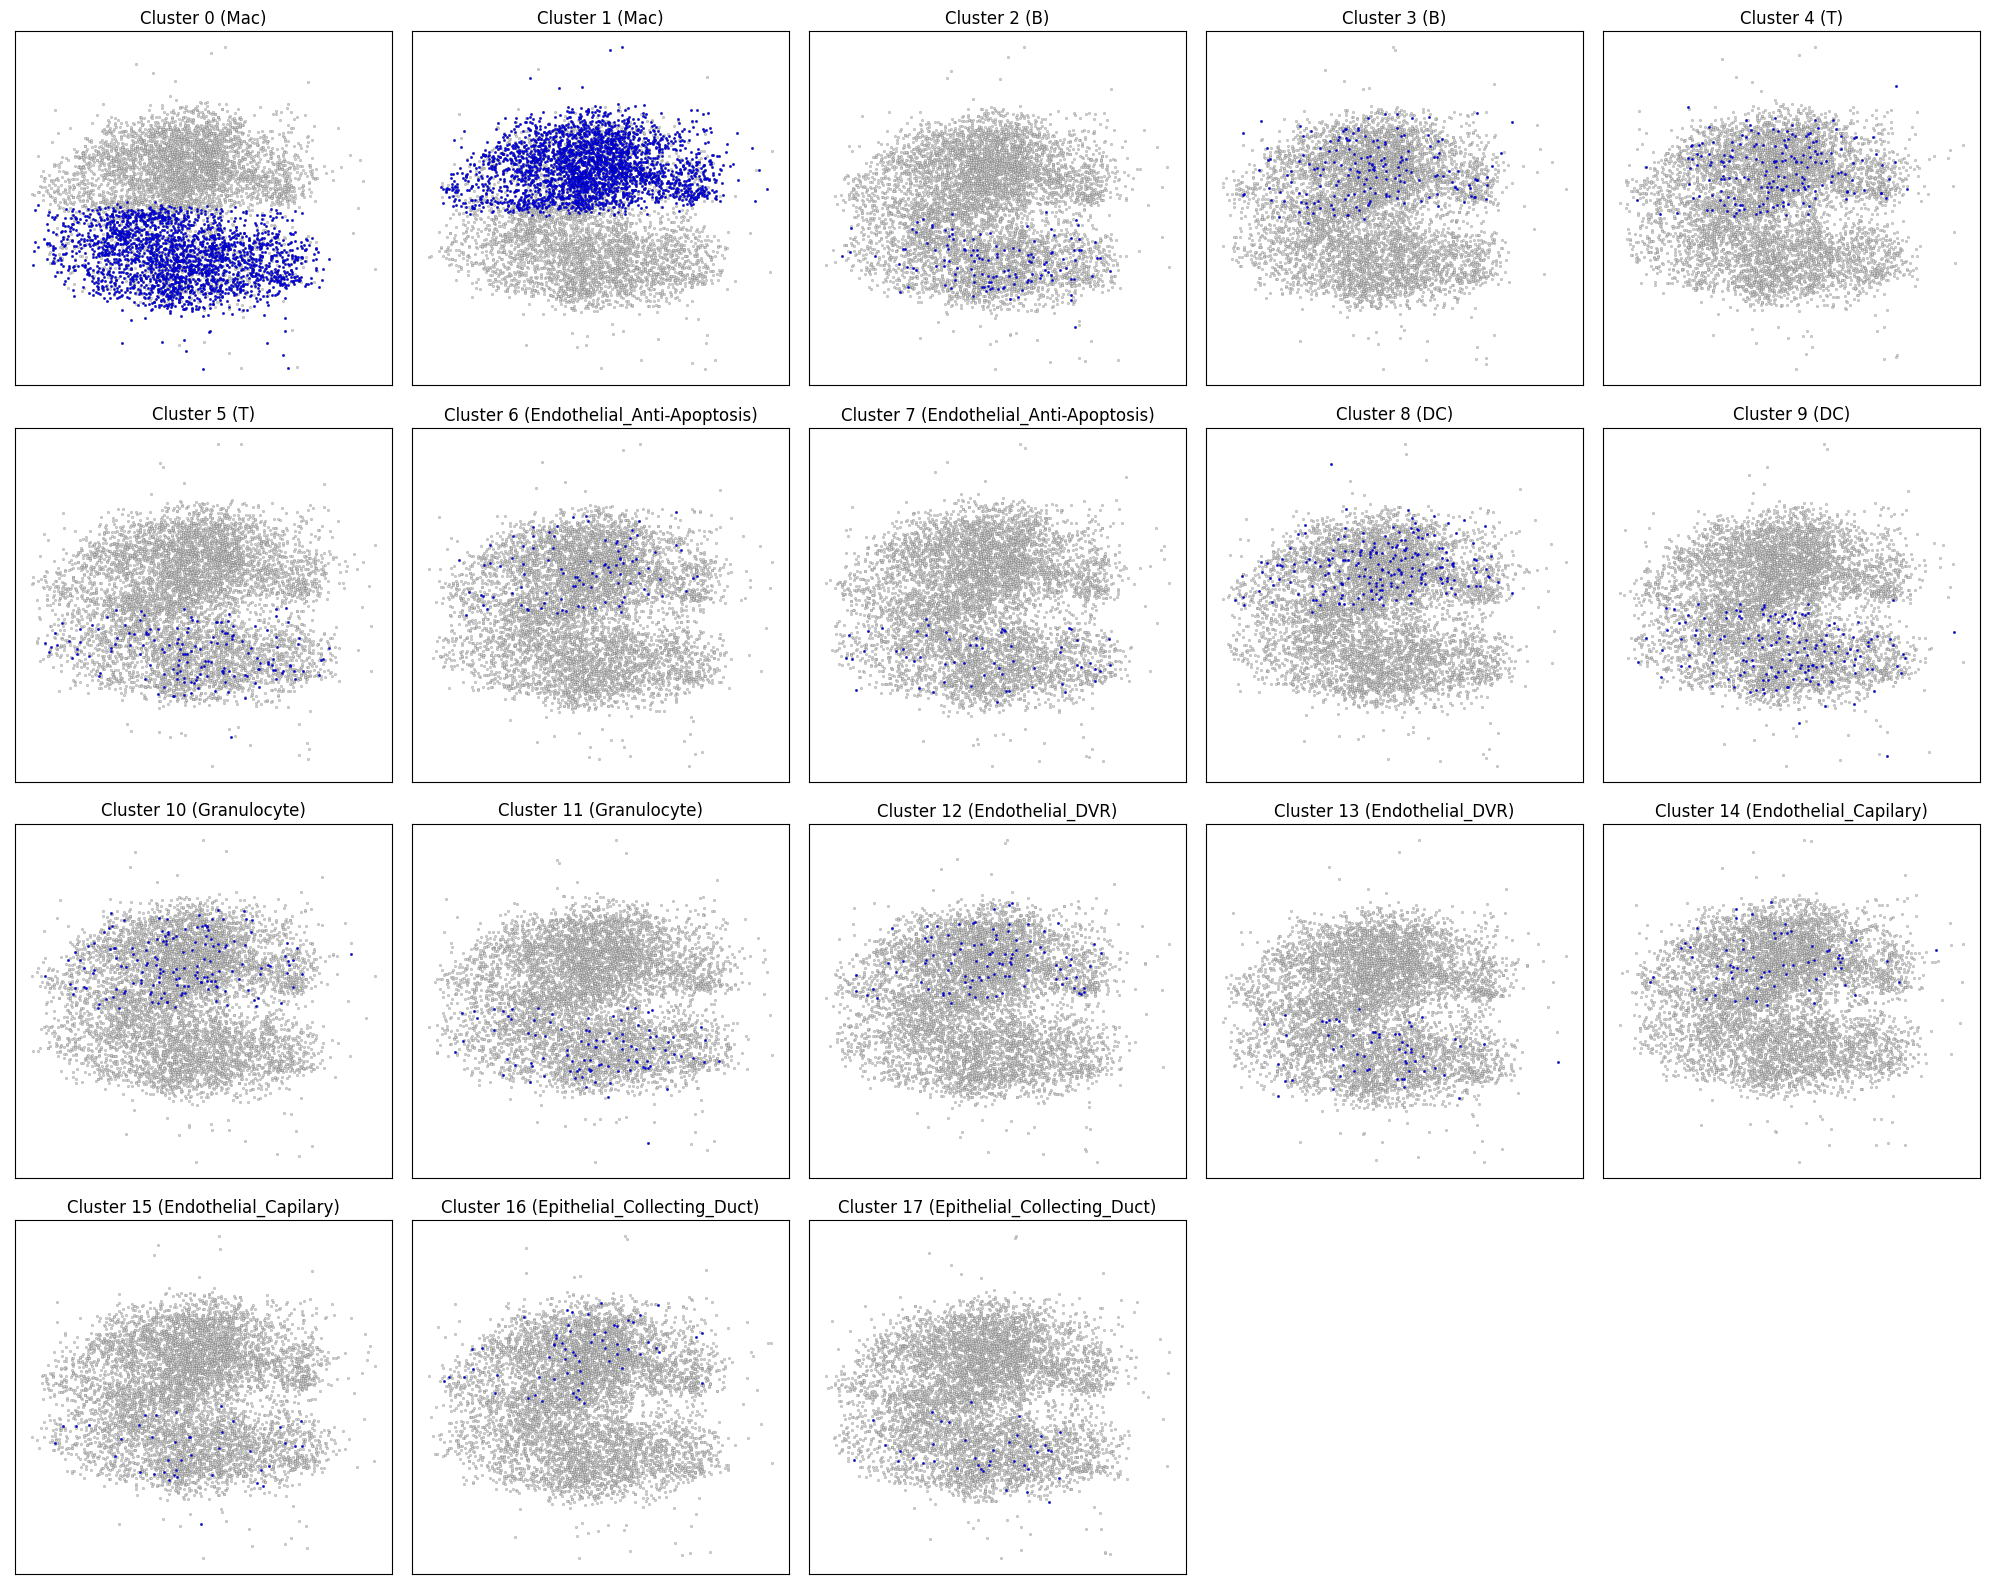

In [12]:
import numpy as np
from spaceoracle.plotting.niche import get_grid_layout
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

seed = 1
score_thresh = 0.2
jitter_scale = 0.5  # Adjust the scale of jitter (smaller values for finer jitter)

cluster_annot = 'ct2'
clusters = adata.obs[cluster_annot].unique()
betas = estimator.betadata.values
cell_types = adata.obs[cluster_annot]
labels = np.full(len(betas), -1, dtype=int)
range_n_clusters = range(2, 5)  # Range of clusters to try

for cell_type in clusters:
    subset_idxs = np.where(cell_types == cell_type)[0]
    subset = betas[subset_idxs]

    best_score = -1
    best_n_clusters = 2

    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
        cluster_labels = kmeans.fit_predict(subset)
        if len(set(cluster_labels)) > 1: 
            score = silhouette_score(subset, cluster_labels)
            if score > best_score:
                best_score = score
                best_n_clusters = n_clusters
    
    if best_score < score_thresh:  
        best_n_clusters = 1

    print(cell_type, best_score)

    best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=seed)
    best_labels = best_kmeans.fit_predict(subset)

    labels[subset_idxs] = best_labels + np.max(labels) + 1

rows, cols = get_grid_layout(len(np.unique(labels)), preferred_cols=None)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = axes.flatten()

for i in np.unique(labels):
    cluster_mask = labels == i
    celltype = cell_types[cluster_mask][0]

    jitter = np.random.normal(scale=jitter_scale, size=adata.obsm['spatial'].shape)
    
    axes[i].scatter(
        adata.obsm['spatial'][:, 0] + jitter[:, 0], adata.obsm['spatial'][:, 1] + jitter[:, 1],
        c='lightgray', s=3, edgecolors='black', linewidth=0.1
    )
    
    axes[i].scatter(
        adata.obsm['spatial'][cluster_mask, 0] + jitter[cluster_mask, 0],
        adata.obsm['spatial'][cluster_mask, 1] + jitter[cluster_mask, 1],
        c='blue', s=3, edgecolors='black', linewidth=0.1
    )
    
    axes[i].set_title(f'Cluster {i} ({celltype})')
    axes[i].set_xticks([])  
    axes[i].set_yticks([])  

for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
